In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pycbc
from pycbc.types import FrequencySeries
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from gstlal import chirptime
from functools import partial


import h5py
import scipy

In [2]:
def make_td_waveform(
        mass1, mass2,
        distance, inclination, coa_phase,
        spin1x, spin1y, spin1z,
        spin2x, spin2y, spin2z,
        delta_t, f_lower,
        approximant='IMRPhenomPv2'):
    
    hp, hc = get_td_waveform(approximant=approximant,\
        mass1=mass1, mass2=mass2,\
        distance=distance,\
        inclination=inclination, coa_phase=coa_phase,\
        spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,\
        spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,\
        delta_t=delta_t, f_lower=f_lower)
    
    
    hp.start_time=0
    hc.start_time=0
    start_time = 0
    end_time = len(hp)*delta_t
    
    MSUN_KG = chirptime.Msun
    ringtime = chirptime.ringtime(60*MSUN_KG, spin1z+spin2z)
    #if ringtime<end_time:
    #    end_time=ringtime
    
    timeshift = np.argmax(hp-1j*hc)*delta_t  # make sure h=hmax when t=0
    timestamp = np.linspace(start_time, end_time, len(hp))-timeshift
    
    mask = timestamp<ringtime
    
    return timestamp[mask], hp[mask]

In [3]:
# rescale
def f_of_tau(tau, chirp_mass):
    '''Eq 4.20 of GW'''
    return 134 * (1.21/chirp_mass)**(5/8) * (1/tau)**(3/8)


def tau_of_f(f, chirp_mass):
    '''Eq 4.21 of GW'''
    return 2.18*(1.21/chirp_mass)**(5/3)*(100/f)**(8/3)


def sampling_density(t, m1, m2, a1, a2, t_start, t_end):    
    total_mass = m1+m2
    chirp_mass = (m1*m2)**(3/5) / total_mass**(1/5)
    
    MSUN_KG = chirptime.Msun
    time_ISCO_2_merger = -chirptime.mergetime(total_mass*MSUN_KG)  # <0 (?)
    #time_ringdown = chirptime.ringtime(total_mass*MSUN_KG, a1+a2)  # >0
    
    time_ringdown = t_end
    #t_end = min(time_ringdown, t_end)
    #time_ringdown = min(time_ringdown, t_end)
    
    freq_ISCO = f_of_tau(-time_ISCO_2_merger, chirp_mass)
    freq_ringdown = chirptime.ringf(total_mass*MSUN_KG, a1+a2)
    
    # *assume* :
    # t in [-inf, time_ISCO_2_merger]: sample density ~ |t|^(-3/8) 
    # t in [time_ISCO_2_merger, t_end]: sample density ~ freq, where freq goes from freq_ISCO to freq_ringdown
    # rho \propto f
    
    b = (-time_ISCO_2_merger) ** (-3/8)
    eta = freq_ringdown/freq_ISCO
    k = b*(eta-1)/(t_end-time_ISCO_2_merger)
    
    # normalize so that \int_{t_start}^{t_end} \rho(t) dt = 1
    C = 8/5*(-t_start)**(5/8) - 8/5*(-time_ISCO_2_merger)**(5/8) + 1/2*b*(1+eta)*(t_end-time_ISCO_2_merger)
    C = 1/C
    
    if t<time_ISCO_2_merger:
        return C*(-t)**(-3/8)
    else:
        return C* (k*(t-time_ISCO_2_merger)+b)
    
    
def sampling_density_fullarray(t, m1, m2, a1, a2, t_start, t_end):    
    total_mass = m1+m2
    chirp_mass = (m1*m2)**(3/5) / total_mass**(1/5)
    
    MSUN_KG = chirptime.Msun
    time_ISCO_2_merger = -chirptime.mergetime(total_mass*MSUN_KG)  # <0 (?)
    #time_ringdown = chirptime.ringtime(total_mass*MSUN_KG, a1+a2)  # >0
    
    time_ringdown = t_end
    #t_end = min(time_ringdown, t_end)
    #time_ringdown = min(time_ringdown, t_end)
    
    freq_ISCO = f_of_tau(-time_ISCO_2_merger, chirp_mass)
    freq_ringdown = chirptime.ringf(total_mass*MSUN_KG, a1+a2)
    
    # *assume* :
    # t in [-inf, time_ISCO_2_merger]: sample density ~ |t|^(-3/8) 
    # t in [time_ISCO_2_merger, t_end]: sample density ~ freq, where freq goes from freq_ISCO to freq_ringdown
    # rho \propto f
    
    b = (-time_ISCO_2_merger) ** (-3/8)
    eta = freq_ringdown/freq_ISCO
    k = b*(eta-1)/(t_end-time_ISCO_2_merger)
    
    # normalize so that \int_{t_start}^{t_end} \rho(t) dt = 1
    C = 8/5*(-t_start)**(5/8) - 8/5*(-time_ISCO_2_merger)**(5/8) + 1/2*b*(1+eta)*(t_end-time_ISCO_2_merger)
    C = 1/C
    
    mask1 = t<time_ISCO_2_merger
    t1 = t[mask1]
    rho1 = C*(-t1)**(-3/8)
    
    mask2 = t>=time_ISCO_2_merger
    t2 = t[mask2]
    rho2 =C* (k*(t2-time_ISCO_2_merger)+b)
    
    
    return np.append(rho1,rho2)
    
    
def real2training_stretch(timestamp, h, m1, m2, a1, a2, ref_freq=50):
    t_start = timestamp[0]
    t_end = timestamp[-1]
    dt = timestamp[1] - timestamp[0]
    ntime = len(timestamp)
    
    chirp_mass = (m1*m2)**(3/5) / (m1+m2)**(1/5)
    
    tr = tau_of_f(ref_freq, chirp_mass)
    index = np.argmin(abs(timestamp-tr))
    tr_in_sample = timestamp[index]
    
    fr_density = sampling_density(tr_in_sample, m1, m2, a1, a2, t_start, t_end)
    freq_array = sampling_density_fullarray(timestamp, m1, m2, a1, a2, t_start, t_end)/fr_density*ref_freq
    freq_array1 = freq_array[:index][::-1]
    freq_array2 = freq_array[index+1:]
    
    accu_freq_1 = -np.add.accumulate(freq_array1)[::-1]
    accu_freq_2 = np.add.accumulate(freq_array2)
    accu_freq = np.append(accu_freq_1,0)
    accu_freq = np.append(accu_freq,accu_freq_2)
    
    new_timestamp = np.zeros(ntime) + tr_in_sample + accu_freq*dt/ref_freq
    
    adjusted_timestamp = new_timestamp*10
    adjusted_h = h*1e19

    return adjusted_timestamp, adjusted_h
def rejection_sampling(pdf_func, xmin, xmax, Nsample, ymax=None):
    '''
    Rejection sampling for 1-D pdf (can be non-normalized).
    
    Can be optimized for efficiency (especially at low pdf region), but I am too lazy.
    '''
    samples = []
    if ymax is None:
        x_array = np.linspace(xmin, xmax, 1000)
        test_pdf = []
        for temp_x in x_array:
            test_pdf.append(pdf_func(temp_x))
        pdf_max = max(test_pdf)
    else:
        pdf_max = ymax
    
    #def g(x):
    #    return pdf_func(x)*1.2
    g = pdf_max*1.05
    while(len(samples)<Nsample):
        xi = np.random.uniform(low=xmin, high=xmax)
        eta = np.random.uniform(low=0, high=g)
        if eta<pdf_func(xi):
            samples.append(xi)
            
    return np.array(samples)

def real2training_resample(timestamp, h, m1, m2, a1, a2):
    t_start = timestamp[0]
    t_end = timestamp[-1]
    ntime = len(timestamp)
    pdf = partial(sampling_density, m1=m1, m2=m2, a1=0, a2=0, t_start=t_start, t_end=t_end)
    timestamp_resampled = rejection_sampling(pdf, t_start, t_end, ntime)
    timestamp_resampled = np.sort(timestamp_resampled)
    hp_interp = np.interp(timestamp_resampled, timestamp, h)

    adjusted_timestamp = timestamp_resampled*100
    adjusted_h = hp_interp*1e19

    return adjusted_timestamp, adjusted_h

In [4]:
def real2training_stretch_resample(timestamp, h, m1, m2, a1, a2, ref_freq=50):
    t_start = timestamp[0]
    t_end = timestamp[-1]
    dt = timestamp[1] - timestamp[0]
    ntime = len(timestamp)
    
    chirp_mass = (m1*m2)**(3/5) / (m1+m2)**(1/5)
    
    tr = tau_of_f(ref_freq, chirp_mass)
    index = np.argmin(abs(timestamp-tr))
    tr_in_sample = timestamp[index]
    
    fr_density = sampling_density(tr_in_sample, m1, m2, a1, a2, t_start, t_end)
    freq_array = sampling_density_fullarray(timestamp, m1, m2, a1, a2, t_start, t_end)/fr_density*ref_freq
    freq_array1 = freq_array[:index][::-1]
    freq_array2 = freq_array[index+1:]
    
    accu_freq_1 = -np.add.accumulate(freq_array1)[::-1]
    accu_freq_2 = np.add.accumulate(freq_array2)
    accu_freq = np.append(accu_freq_1,0)
    accu_freq = np.append(accu_freq,accu_freq_2)
    
    new_timestamp = np.zeros(ntime) + tr_in_sample + accu_freq*dt/ref_freq
    
    stretched_timestamp = new_timestamp*10
    stretched_h = h*1e19
    
    resampled_timestamp = np.linspace(stretched_timestamp[0], stretched_timestamp[-1], len(stretched_timestamp))
    interpolator = scipy.interpolate.CubicSpline(stretched_timestamp, stretched_h)  # CubicSpline, interp1d
    resampled_h = interpolator(resampled_timestamp)
    #resampled_h = np.interp(resampled_timestamp, stretched_timestamp, stretched_h)
    
    return stretched_timestamp, stretched_h, resampled_timestamp, resampled_h

In [5]:
save_folder = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/data/'

# Non-aligned spin

In [6]:
def generate_random_spin(Nsample, a_max=0.99):
    ''' 
    a random point in unit sphere
    (r,theta,phi) is the sphere coordinate
    '''
    r = np.random.random(Nsample) * a_max
    phi = 2*np.pi*np.random.random(Nsample)
    cos_theta = 2*np.random.random(Nsample)-1.0
    
    sin_theta = np.sqrt(1-cos_theta**2)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    spin_x = r*sin_theta*cos_phi
    spin_y = r*sin_theta*sin_phi
    spin_z = r*cos_theta
    
    return spin_x, spin_y, spin_z



In [53]:
N=10
#q_train = np.logspace(np.log10(0.5),0,N)  # q from 0.5 to 1
q_train = np.linspace(0.5,1,N)

Mtot=60

mass_1_train = Mtot/(1+q_train)
mass_2_train = mass_1_train*q_train

spin1x_train,spin1y_train,spin1z_train = generate_random_spin(N, a_max=0.5)
spin2x_train,spin2y_train,spin2z_train = generate_random_spin(N, a_max=0.5)

luminosity_distance = 1
iota = 0
phase = 0


deltat = 1/4096/2  # use higher resolution
flow = 20

data_dict = dict()
data_dict['time_stretched'] = []
data_dict['strain_stretched'] = []
data_dict['time_stretched_resampled'] = []
data_dict['strain_stretched_resampled'] = []
data_dict['waveform_models'] = []

data_dict['source_parameters'] = dict()
parameter_name_list = ['mass1','mass2','spin1x','spin1y','spin1z','spin2x','spin2y','spin2z']
for paraname in parameter_name_list:
    data_dict['source_parameters'][paraname] = []

In [54]:
def padding_data_dict(data_dict):
    time = data_dict['time']
    lengths = []
    for t in time:
        lengths.append(len(t))
    max_length = max(lengths)
    
    for i in range(len(data_dict['time'])):
        temp_len = lengths[i]
        len_diff = max_length-temp_len
        if len_diff>0:
            paddings = np.full(len_diff, np.nan)
            data_dict['strain'][i] = np.append(data_dict['strain'][i], paddings)
            data_dict['time'][i] = np.append(data_dict['time'][i], paddings)
            
    return data_dict

def trimming_data_dict(data_dict):
    time = data_dict['time_stretched_resampled']
    lengths = []
    for t in time:
        lengths.append(len(t))
    min_length = min(lengths)
    
    for i in range(len(time)):
        temp_len = lengths[i]
        len_diff = temp_len - min_length
        if len_diff>0:
            index_to_delete = np.random.permutation(temp_len//10) + temp_len//100  # do not delete first several points
            index_to_delete = index_to_delete[:len_diff]
            data_dict['time_stretched_resampled'][i] = np.delete(data_dict['time_stretched_resampled'][i], index_to_delete)
            data_dict['strain_stretched_resampled'][i] = np.delete(data_dict['strain_stretched_resampled'][i], index_to_delete)
            data_dict['time_stretched'][i] = np.delete(data_dict['time_stretched'][i], index_to_delete)
            data_dict['strain_stretched'][i] = np.delete(data_dict['strain_stretched'][i], index_to_delete)
            
    return data_dict


def trimming_multimodel_data_dict(data_dict, ref_model_index):
    n_model = len(data_dict['waveform_models'])
    n_physample = len(data_dict['source_parameters']['mass1'])
    ref_waveform_index = np.arange(ref_model_index, n_physample*n_model+ref_model_index, n_model)
    
    time = data_dict['time_stretched_resampled']
    lengths = []
    for t in time:
        lengths.append(len(t))
    print("Original data:")
    for i, approx in enumerate(data_dict['waveform_models']):
        subwfl = lengths[i::n_model]
        print(f"{approx}: Max length: {max(subwfl)}, min length: {min(subwfl)}.")
    
    min_length = min(lengths)
    for i in range(len(time)):
        temp_len = lengths[i]
        len_diff = temp_len - min_length
        if len_diff>0:
            index_to_delete = np.random.permutation(int(temp_len*0.8)) + temp_len//100  # do not delete first several points
            index_to_delete = index_to_delete[:len_diff]
            data_dict['time_stretched_resampled'][i] = np.delete(data_dict['time_stretched_resampled'][i], index_to_delete)
            data_dict['strain_stretched_resampled'][i] = np.delete(data_dict['strain_stretched_resampled'][i], index_to_delete)
            data_dict['time_stretched'][i] = np.delete(data_dict['time_stretched'][i], index_to_delete)
            data_dict['strain_stretched'][i] = np.delete(data_dict['strain_stretched'][i], index_to_delete)

    time = data_dict['time_stretched_resampled']
    lengths = []
    for t in time:
        lengths.append(len(t))
    print("\nAfter index alignment with the shorest waveform:")
    for i, approx in enumerate(data_dict['waveform_models']):
        subwfl = lengths[i::n_model]
        print(f"{approx}: Max length: {max(subwfl)}, min length: {min(subwfl)}.")
            
    return data_dict

def align_with_shortest_model(tlist,hlist):
    max_tstart = min(tlist[0])
    for tarray in tlist:
        if min(tarray)>max_tstart:
            max_tstart = min(tarray)
    
    tlist_cut = []
    hlist_cut = []
    for i, harray in enumerate(hlist):
        mask = tlist[i]>=max_tstart
        tlist_cut.append(tlist[i][mask])
        hlist_cut.append(harray[mask])
    
    return tlist_cut, hlist_cut

def cut_zero(tlist,hlist):
    t_zero_list = []
    n_approx = len(tlist)

    for i in range(n_approx):
        zeroindex = np.where(hlist[i]==0.0)[0]
        if len(zeroindex)>0:
            t_zero_list.append(tlist[i][zeroindex[0]])

    if len(t_zero_list)>0:
        min_t_end = min(t_zero_list)

        tlist_cut = []
        hlist_cut = []
        for i in range(n_approx):
            mask = tlist[i]<min_t_end
            tlist_cut.append(tlist[i][mask])
            hlist_cut.append(hlist[i][mask])
        return tlist_cut, hlist_cut
    else:
        return tlist,hlist

In [55]:

waveform_index = 0
wfl = []
approx_list = ['IMRPhenomPv2', 'SEOBNRv4P']
data_dict['waveform_models'] = approx_list
n_approx = len(approx_list)
for waveform_index in range(N):
    mass_1_temp = mass_1_train[waveform_index]
    mass_2_temp = mass_2_train[waveform_index]

    spin1x_temp = spin1x_train[waveform_index]
    spin1y_temp = spin1x_train[waveform_index]
    spin1z_temp = spin1x_train[waveform_index]

    spin2x_temp = spin1x_train[waveform_index]
    spin2y_temp = spin1x_train[waveform_index]
    spin2z_temp = spin1x_train[waveform_index]
    
    tlist_temp = []
    hlist_temp = []
    for approx in approx_list:
        timestamp_temp, hp_temp = make_td_waveform(mass1=mass_1_temp, mass2=mass_2_temp,\
            distance=1,\
            inclination=0, coa_phase=0,\
            spin1x=spin1x_temp, spin1y=spin1y_temp, spin1z=spin1z_temp,\
            spin2x=spin2x_temp, spin2y=spin2y_temp, spin2z=spin2z_temp,\
            delta_t=deltat, f_lower=flow, approximant=approx)

        tlist_temp.append(timestamp_temp)
        hlist_temp.append(hp_temp)

    tlist_temp, hlist_temp = align_with_shortest_model(tlist_temp, hlist_temp)
    tlist_temp, hlist_temp = cut_zero(tlist_temp, hlist_temp)
    for approx_index in range(n_approx):
        #wfl.append(len(timestamp_temp))
        timestamp_temp = tlist_temp[approx_index]
        hp_temp = hlist_temp[approx_index]
        stretched_timestamp, stretched_h, resampled_timestamp, resampled_h =\
                real2training_stretch_resample(timestamp_temp, hp_temp, mass_1_temp, mass_2_temp, spin1z_temp, spin2z_temp)

        
        data_dict['time_stretched'].append(stretched_timestamp)
        data_dict['strain_stretched'].append(stretched_h)
        data_dict['time_stretched_resampled'].append(resampled_timestamp)
        data_dict['strain_stretched_resampled'].append(resampled_h)
    
    data_dict['source_parameters']['mass1'].append(mass_1_temp)
    data_dict['source_parameters']['mass2'].append(mass_2_temp)
    
    data_dict['source_parameters']['spin1x'].append(spin1x_temp)
    data_dict['source_parameters']['spin1y'].append(spin1y_temp)
    data_dict['source_parameters']['spin1z'].append(spin1z_temp)
    data_dict['source_parameters']['spin2x'].append(spin2x_temp)
    data_dict['source_parameters']['spin2y'].append(spin2y_temp)
    data_dict['source_parameters']['spin2z'].append(spin2z_temp)


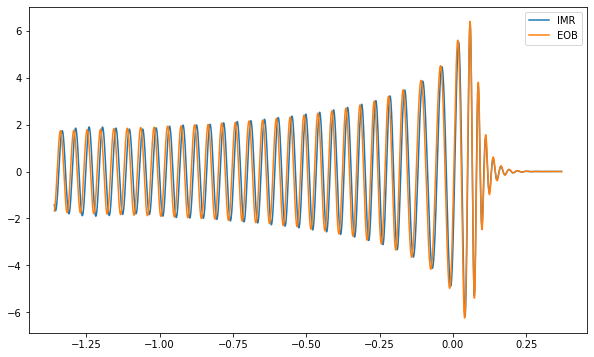

In [56]:
look_index = 1

t_imr = data_dict['time_stretched_resampled'][n_approx*look_index]
h_imr = data_dict['strain_stretched_resampled'][n_approx*look_index]

t_eob = data_dict['time_stretched_resampled'][n_approx*look_index+1]
h_eob = data_dict['strain_stretched_resampled'][n_approx*look_index+1]


plt.figure(figsize=(10,6))
plt.plot(t_imr,h_imr, label='IMR')
plt.plot(t_eob,h_eob, label='EOB')
plt.legend()
#plt.xlim(-1.8,0.5)
plt.show()


In [57]:
data_dict = trimming_multimodel_data_dict(data_dict, ref_model_index=1)


Original data:
IMRPhenomPv2: Max length: 8289, min length: 6928.
SEOBNRv4P: Max length: 8289, min length: 6928.

After index alignment with the shorest waveform:
IMRPhenomPv2: Max length: 6928, min length: 6928.
SEOBNRv4P: Max length: 6928, min length: 6928.


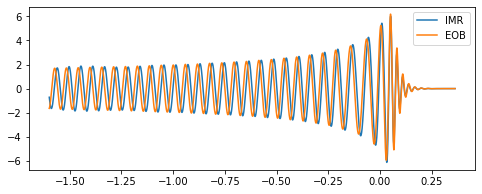

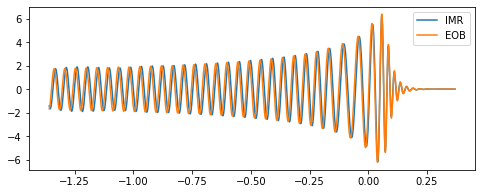

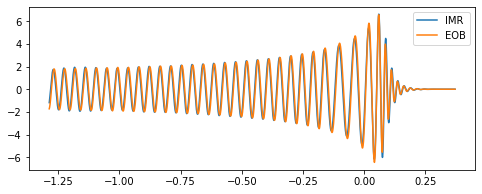

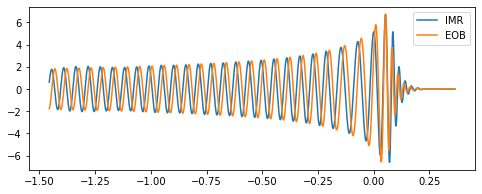

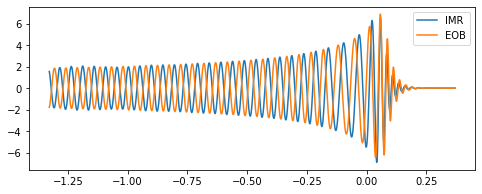

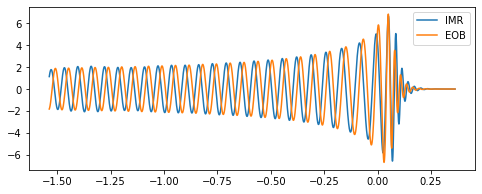

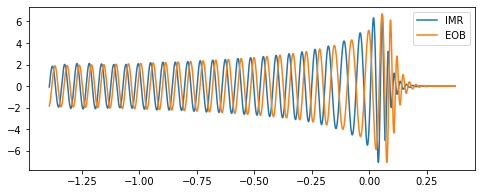

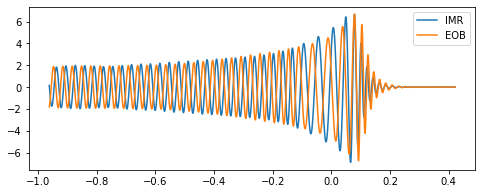

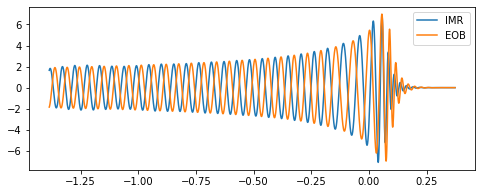

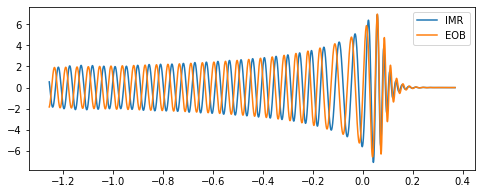

In [58]:
for look_index in range(10):

    t_imr = data_dict['time_stretched_resampled'][n_approx*look_index]
    h_imr = data_dict['strain_stretched_resampled'][n_approx*look_index]

    t_eob = data_dict['time_stretched_resampled'][n_approx*look_index+1]
    h_eob = data_dict['strain_stretched_resampled'][n_approx*look_index+1]


    plt.figure(figsize=(8,3))
    plt.plot(t_imr,h_imr, label='IMR')
    plt.plot(t_eob,h_eob, label='EOB')
    plt.legend()
    #plt.xlim(-1.8,0.5)
    plt.show()

In [59]:
h5filename = save_folder + 'gw_stchresp_nasp5_qp5_2N2000_Pv2v4P.h5'

with h5py.File(h5filename, 'w') as file:
    grp = file.create_group("waveform_models")
    for i,approx in enumerate(data_dict['waveform_models']):
        grp.create_dataset(approx, data=[i])
    file.create_dataset('time_stretched', data=data_dict['time_stretched'])
    file.create_dataset('strain_stretched', data=data_dict['strain_stretched'])
    file.create_dataset('time_stretched_resampled', data=data_dict['time_stretched_resampled'])
    file.create_dataset('strain_stretched_resampled', data=data_dict['strain_stretched_resampled'])
    grp = file.create_group("source_parameters")
    for paraname in parameter_name_list:
        grp.create_dataset(paraname, data=data_dict['source_parameters'][paraname])